### Nome: Samuel Felipe dos Santos

# PROJETO 4 - AUTOENCODER

Relatório realizado para disciplina de Redes Neurais, contendo experimentos realizados com a rede SOM. O relatório foi desenvolvido fazendo uso da ferramenta Jupyter Notebook, e pode ser melhor visualizado em <a href="https://github.com/felipe-samuel/NeuralNetworksProjects/blob/master/project_04-autoencoder_experiments.ipynb">https://github.com/felipe-samuel/NeuralNetworksProjects/blob/master/project_04-autoencoder_experiments.ipynb</a>

## Objetivos

Esse projeto teve como principais objetivos:

* Implementar um autoencoder;
* Testa-lo nos datasets MNIST e Fashion MNIST;
* Variar o número de neurônios internos e de camadas;
* Visualizar a codificação gerada pelos neurônios da primeira camada oculta.

## Metodologia

Nessa secção será detalhada a metodologia experimental utilizada para alcançar os objetivos anteriormente mencionados.

#### Bibliotecas Utilizadas
Foi utilizada a linguagem de programação Python 3 para realizar a implementação dos experimentos. Para a criação da rede neural, e tratamento dos dados foi utilizada a biblioteca Pytorch, e para a visualização, as bibliotecas Matplotlib e Pandas. O trecho de código a seguir mostra todas as bibliotecas utilizadas.

In [47]:
import torch
from torch import nn
from torch.nn import functional
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

from torchsummary import summary

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display, HTML

#### Datasets

Foram realizados experimentos com dois datasets, ambos disponíveis na biblioteca Pytorch:

* **MNIST:** Dataset de dígitos escritos a mão. Possui 60000 exemplos de treinamento e 10000 para teste/validação, que tomam forma de imagens monocromáticas com resolução de 28x28 pixels. Disponível para download em <a href="https://www.it-swarm.net/pt/jupyter/realcar-erros-de-digitacao-na-marcacao-jupyter-do-notebook/826521767/" target="_blank">https://www.it-swarm.net/pt/jupyter/realcar-erros-de-digitacao-na-marcacao-jupyter-do-notebook/826521767/</a>.


* **Fashion MNIST:** Dataset com peças de roupas, feito para poder ser utilizado como um substituto direto do MNIST, possuindo a mesma quantidade de classes, exemplos e e resolução de imagem. Disponível para download em  <a href="https://github.com/zalandoresearch/fashion-mnist" target="_blank">https://github.com/zalandoresearch/fashion-mnist</a>.

#### Carregando os Datasets

Os datasets são carregados para uso por objetos da classe DataLoader. No código abaixo os datasets MNIST e Fashion MNIST são carregados.

In [2]:
mnist_transform   = transforms.ToTensor()
f_mnist_transform = transforms.ToTensor()

In [3]:
mnist_train = datasets.MNIST(root='./datasets', train=True,  transform=mnist_transform, target_transform=None, download=True)
mnist_val   = datasets.MNIST(root='./datasets', train=False, transform=mnist_transform, target_transform=None, download=True)

f_mnist_train = datasets.FashionMNIST(root='./datasets', train=True,  transform=f_mnist_transform, target_transform=None, download=True)
f_mnist_val   = datasets.FashionMNIST(root='./datasets', train=False, transform=f_mnist_transform, target_transform=None, download=True)

In [4]:
loader_mnist_train = torch.utils.data.DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=4)
loader_mnist_val   = torch.utils.data.DataLoader(mnist_val  , batch_size=1,   shuffle=True, num_workers=4)

loader_f_mnist_train = torch.utils.data.DataLoader(f_mnist_train, batch_size=128, shuffle=True, num_workers=4)
loader_f_mnist_val   = torch.utils.data.DataLoader(f_mnist_val  , batch_size=1,   shuffle=True, num_workers=4)

#### Implementação do Autoencoder

Foi implementado um autoencoder na forma de uma classe, cuja inicialização possui os seguintes parametros:

* **input_size:** Tamanho dos exemplos de entrada da rede, por padrão, definido como 784, o tamanho dos exemplos da base de dados MNIST e Fashion MNIST quando convertidas para um vetor unidimensional.

* **layers_size:** Uma lista que indica a quantidade de neurônios de cada camada densa do encoder e do decoder da rede, de forma que o autoencoder criado por essa classe terá o dobro da quantidade de camadas especificadas. Ex:   layers_size = [128,64,32], quantidade de neurônios das camadas densas do encoder = [128,64,32], camadas do decoder = [64, 128, 784]. Valor padrão = [128]

* **linear:** Indica se serão utilizados apenas camadas lineares no autoencoder. Caso Verdadeiro, são utilizadas apenas camadas densas, sem função de ativação. Caso Falso, as camadas densas são seguidas da função de ativação ReLu, com exceção da última, que é seguida da função de ativação Sigmoid. Valor padrão = False

O código abaixo mostra a inicialização da classe.


In [5]:
class Autoencoder(nn.Module):
    def __init__(self, input_size = 784,  layers_size = [ 128 ], linear=False ):
        super(Autoencoder,self).__init__()
        self.encoder = []
        self.decoder = []
        self.input_size = input_size
        self.layers_size = layers_size
        self.layers_size = [ input_size ] + self.layers_size
        
        for i in range(0,len(self.layers_size)-1 ):
            if linear:
                block = nn.Linear(self.layers_size[i], self.layers_size[i+1])
            else:
                block = nn.Sequential(nn.Linear(self.layers_size[i], self.layers_size[i+1]), nn.ReLU(True))
            self.encoder += [ block.cuda() ]

        for i in range(0,len(self.layers_size)-2):
            if linear:
                block = nn.Linear(self.layers_size[-1-i], self.layers_size[-1-(i+1)])
            else:
                block = nn.Sequential(nn.Linear(self.layers_size[-1-i], self.layers_size[-1-(i+1)]), nn.ReLU(True))            
            self.decoder += [ block.cuda() ]
        if linear:
            block = nn.Linear(self.layers_size[1], self.layers_size[0])
        else:
            block = nn.Sequential(nn.Linear(self.layers_size[1], self.layers_size[0]), nn.Sigmoid())
        self.decoder += [ block.cuda() ]
                
        self.encoder = nn.ModuleList(self.encoder)
        self.decoder = nn.ModuleList(self.decoder)

O método *foward* indica como é realizada a passada para frente dos dados pela rede, onde no autoencoder criado, a entrada é convertida um vetor de uma dimensão, e então é passada por todas as camadas.

In [6]:
def forward(self,x):
    shape = x.shape
    x = torch.flatten(x, 1).cuda()
    for i in range(len(self.layers_size)-1):
        x = self.encoder[i](x)
    for i in range(len(self.layers_size)-1):
        x = self.decoder[i](x)
    x = torch.reshape(x, shape)
    return x
Autoencoder.forward = forward

O método *train* realiza o treinamento da rede, tendo os seguintes parâmetros como entrada:

* **loader:** Um objeto da classe DataLoader do Pytorch que carregue os exemplos de treinamento do dataset desejado;

* **loader_eval:** Um objeto da classe DataLoader do Pytorch que carregue os exemplos de validação do dataset desejado;
    
* **epochs:** Quantidade de épocas que serão executadas, ou seja, a quantidade de vezes na qual todos os exemplos do dataset serão apresentados a rede. Valor padrão = 50;

* **eval_freq:** Quantidade de eṕocas entre as quais o modelo tem seu desempenho avaliado no conjunto de validação. Valor padrão = 10.

Foi utilizado o otimizador Adam, com taxa de aprendizado de 0,001 e constante de penalidade L2 de 0,00001 (*weight_decay*). É utilizada a função de perda do Erro Quadrático Médio, medindo a diferença entre a imagem gerada pelo autoencoder e a imagem de entrada.

O método retorna listas com o erro quadrático médio para cada época para o conjunto de treino e validação.

In [7]:
def train(self, loader, loader_eval, epochs=50, eval_freq = 10):
    log_loss = []
    log_loss_val = []
    optimizer = torch.optim.Adam(self.parameters(), weight_decay=1e-5)
    distance = nn.MSELoss()
    with tqdm(total=epochs, ascii=True, desc='epoch: 0 loss: None') as pbar:
        i = 1
        for epoch in range(epochs):
            epoch_loss = []
            epoch_val  = []  
            for data in loader:
                img, _ = data
                img = Variable(img).cuda()

                output = self(img)
                loss = distance(output, img)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += [ float(loss.data) ]    
            if i%eval_freq==0:
                loss_val = self.eval(loader_eval, nn.MSELoss())
                log_loss_val += [ loss_val ]
                print('validation loss:', loss_val)
            log_loss += [ np.mean(epoch_loss) ]
            i+=1
            pbar.update(1)
            pbar.set_description_str(desc='epoch:' + str(epoch+1) + ' loss:' + str(float(loss.data)) )
    return log_loss, log_loss_val
Autoencoder.train = train

O método *eval* tem como entrada um DataLoader e uma métrica de distância. Os exemplos contidos no DataLoader são passados pela rede, sendo calculado e retornado a função de distância informada entre as entradas e saidas. Usado para realizar a validação. 

In [8]:
def eval(self, loader, distance):
    log_loss = []
    for data in loader:
        img, _ = data
        img = Variable(img).cuda()

        output = self(img)
        loss = distance(output, img)
        log_loss += [ float(loss) ]
    return np.mean(log_loss)
Autoencoder.eval = eval

#### Otimização dos Parâmetros

A busca dos parâmetros ótimos é feita por meio da função *grid_search*, que avalia redes com cada um dos parâmetros fornecidos a ela. Na implementação desse trabalhos, são otimizados os parâmetros da quantidade de camadas e a quantidade de neurônios em cada camada.

In [9]:
def grid_search(params, train_loader, val_loader, epochs=50, eval_freq = 10, linear=False):
    outputs = {
        'layers_size' : params,    
        'loss_train': [],
        'loss_val': [],
        'loss_val_std': [],
        'loss_': [],
        'loss_val_': [],
        'best_loss': 1000
    }
    
    models = []
    best_model = None
    
    for p in params:
        print('training with ', p , ' layers')
        model = Autoencoder(input_size=784,  layers_size=p, linear=linear).cuda()
        loss, loss_val = model.train(train_loader, val_loader, epochs=epochs, eval_freq=eval_freq)
        outputs['loss_train'] += [loss[-1]]
        outputs['loss_val']   += [loss_val[-1]]
        outputs['loss_']      += [loss]
        outputs['loss_val_']  += [loss_val]
        models += [model]

        if outputs['best_loss'] > loss_val[-1]:
            best_model = model
            outputs['best_loss']  = loss_val[-1]
    return outputs, models, best_model   

In [10]:
def gs_to_dataframes(gs):
    dict_final = {
        'layers_size' : gs['layers_size'],    
        'loss_train': gs['loss_train'],
        'loss_val': gs['loss_val']
    }
    final_results = pd.DataFrame.from_dict(dict_final)
    
    models_results = []
    for i in range(len(gs['loss_'])):
        m_dict = {
             'epochs' : list( range( len(gs['loss_'][i]) ) ),
            'loss_train': gs['loss_'][i],
            'loss_val': []
        }
        
        eval_freq = int( len(gs['loss_'][i]) / len(gs['loss_val_'][i])    )
        last_value = float('nan')
        for value in gs['loss_val_'][i]:
            for j in range(eval_freq - 1):
                m_dict['loss_val'] += [ last_value ]
            m_dict['loss_val'] += [ value ]
            last_value = value
            
        models_results += [ pd.DataFrame.from_dict(m_dict) ]
        
    return final_results, models_results

A seguir pode ser observado os parâmetros que foram testados pelo Grid Search nos experimentos realizados nesse trabalho, onde cada elemento da lista indica uma configuração de quantidade de camadas e neurônios da rede.

Exemplo: o elemento 2 da lista, [32,  16], indica uma configuração de rede onde o encoder possuí duas camadas, com respectivamente 32 e 16 neurônios cada, e o decoder possuí duas camadas, respectivamente, 32 e 784 (tamanho da entrada) neurônios cada.

In [11]:
params = [  [32],  [32,  16], [ 32,  16,  8],
            [64],  [64,  32], [ 64,  32, 16],
           [128], [128,  64], [128,  64, 32] ]

#### Análise dos Resultados

Para realização da analise dos resultados obtidos, são construídos gráficos que apresentão a fução de perda para cada época do treinamento e validação para todos os modelos testados pelo Grid Search, sendo possível observar a influência da quantidade de camadas e neurônios no desempenho da rede.

In [12]:
def plot_learning_curve(tables, params, colors, param_name, xlim = [0,49], ylim = [0.4, 1]):
    plt.rcParams['figure.figsize'] = [15, 5]
    f, axarr = plt.subplots(1, 2)
    i=0
    train_val = ['treino', 'validação']
   
    for i in range(len(tables)):
        axarr[0].plot(tables[i]['epochs'], tables[i]['loss_train'], color=colors[i], label = param_name+'='+str(params[i]) )
    axarr[0].set_title('Treinamento', fontsize=25)
    axarr[0].set_xlabel('épocas')
    axarr[0].set_ylabel('Perda', fontsize=25)

    for i in range(len(tables)):
        axarr[1].plot(tables[i]['epochs'], tables[i]['loss_val'], color=colors[i], label = param_name+'='+str(params[i]) )
    axarr[1].set_title('Validação', fontsize=25)
    axarr[1].set_xlabel('épocas')

    
    axarr[0].set_xlim( xlim )
    axarr[0].set_ylim( ylim )
    axarr[1].set_xlim( xlim )
    axarr[1].set_ylim( ylim )
    
    f.subplots_adjust(hspace=0.3)

    axarr[0].legend(loc='upper left', bbox_to_anchor=(-0.1, 1.3), ncol=7)

Para realizar uma analise qualitativa dos resultados obtidos, para o melhor modelo encontrado pelo Grid Search (o que possuir o menor valor de perda para validação após o treinamento), são mostrados lado a lado, para um exemplo de cada classe da base de dados, a imagem de entrada, a representação gerada pela primeira camada oculta, e a saída gerada pelo autoencoder.

In [13]:
def plot_examples_autoencoder( loader, model, n=10):
    examples = { }
    sampled = np.zeros(n)
    for img, labels in loader:
        img, labels = next(iter(loader))
        if sampled[ int(labels[0]) ] == 0: 
            sampled [ int(labels[0]) ] = 1
            examples[ int(labels[0]) ] = img
        if np.sum(sampled) == n:
            break
        
    for i in range(n):
        plt.figure(figsize=(20, 4))
        plt.subplot(141)
        plt.title('Imagem de Entrada')
        
        imgs = examples[i]
        img = imgs.reshape([28,28])
        plt.imshow(img, cmap='Greys')


        plt.subplot(142)
        plt.title('Codificação Gerada pela Primeira Camada Oculta')

        first_layer_out = model.encoder[0]( torch.flatten(imgs, 1).cuda() ).data.cpu()
        coded_shape = first_layer_out.data.cpu().shape[-1]
        plt.bar(list(range(coded_shape)), first_layer_out.reshape( [coded_shape] ) )


        plt.subplot(143)
        plt.title('Saida da Rede')

        out = model(imgs.cuda())
        plt.imshow(out.data.cpu().reshape([28,28]), cmap='Greys')
        plt.show()

## Experimentos e Resultados

Os experimentos realizados foram divididos em quatro tipos, sendo eles:

1. Experimentos com o dataset MNIST utilizando Autoencoders que possuem camadas não lineares;
2. Experimentos com o dataset Fashion MNIST utilizando Autoencoders que possuem camadas não lineares;
3. Experimentos com o dataset MNIST utilizando Autoencoders que possuem apenas camadas lineares;
4. Experimentos com o dataset Fashion MNIST utilizando Autoencoders que possuem apenas camadas lineares;

Onde para cada tipo, foram realizados a busca pelos parâmetros ótimos usando o Grid Search, a comparação de todos os modelos testados por meio de um gráfico com a perda para cada época, e por fim a análise da saída da rede ao colocar lado a lado exemplos de entrada, a codificação gerada pela primeira camada e a saída do autoencoder.

O código a seguir mostra a execução do Grid Search para cada um dos tipos de experimento.

In [ ]:
gs_mnist, mnist_models, mnist_best_model = grid_search(params, loader_mnist_train,
                                                               loader_mnist_val, epochs=50)

In [ ]:
gs_f_mnist, f_mnist_models, f_mnist_best_model = grid_search(params, loader_f_mnist_train,
                                                                     loader_f_mnist_val, epochs=50)

In [ ]:
gs_mnist_linear, mnist_models_linear, mnist_best_model_linear = grid_search(params, 
                                                                            loader_mnist_train, 
                                                                            loader_mnist_val,
                                                                            epochs=50, linear=True)

In [ ]:
gs_f_mnist_linear, f_mnist_models_linear, f_mnist_best_model_linear = grid_search(params,
                                                                                  loader_f_mnist_train, 
                                                                                  loader_f_mnist_val,
                                                                                  epochs=50, linear=True)

Abaixo são apresentados as tabelas com os resultados do Grig Search do para os quatro tipos de experimentos (MNIST com camadas não lineares, Fashion MNIST com camadas não lineares, MNIST apenas com camadas lineares e Fashion MNIST apenas com camadas lineares, respectivamente).

In [88]:
final_results_mnist, models_results_mnist = gs_to_dataframes(gs_mnist)
display(HTML(
'<b><center>Resultados do Grid Search para o Dataset MNIST com Redes que Possuem Camadas não Lineares</b></center>'
))
display(final_results_mnist.sort_values(by='loss_val'))

,layers_size,loss_train,loss_val
6,[128],0.004074,0.003953
3,[64],0.005932,0.005724
7,"[128, 64]",0.006516,0.006365
4,"[64, 32]",0.010186,0.009837
0,[32],0.010810,0.010442
8,"[128, 64, 32]",0.013745,0.013512
5,"[64, 32, 16]",0.017048,0.016599
1,"[32, 16]",0.018368,0.017974
2,"[32, 16, 8]",0.030218,0.029943


In [89]:
final_results_f_mnist, models_results_f_mnist = gs_to_dataframes(gs_f_mnist)
display(HTML(
'<b><center>Resultados do Grid Search para o Dataset Fashion MNIST com Redes que Possuem Camadas não Lineares</b></center>'
))
display(final_results_f_mnist.sort_values(by='loss_val'))

,layers_size,loss_train,loss_val
6,[128],0.007993,0.008016
3,[64],0.010489,0.010568
7,"[128, 64]",0.010777,0.010867
4,"[64, 32]",0.012791,0.012899
0,[32],0.013162,0.013204
8,"[128, 64, 32]",0.013960,0.013994
1,"[32, 16]",0.015776,0.015824
5,"[64, 32, 16]",0.015921,0.015922
2,"[32, 16, 8]",0.020306,0.020335


In [90]:
final_results_mnist_linear, models_results_mnist_linear = gs_to_dataframes(gs_mnist_linear)
display(HTML(
'<b><center>Resultados do Grid Search para o Dataset MNIST com Redes que Possuem  Apenas Camadas Lineares</b></center>'))
display(final_results_mnist_linear.sort_values(by='loss_val'))

,layers_size,loss_train,loss_val
6,[128],0.004482,0.004390
3,[64],0.009467,0.009212
7,"[128, 64]",0.009480,0.009213
0,[32],0.017401,0.016960
8,"[128, 64, 32]",0.017411,0.016974
4,"[64, 32]",0.017409,0.016978
5,"[64, 32, 16]",0.027424,0.026959
1,"[32, 16]",0.027419,0.026972
2,"[32, 16, 8]",0.037967,0.037533


In [91]:
final_results_f_mnist_linear, models_results_f_mnist_linear = gs_to_dataframes(gs_f_mnist_linear)
display(HTML(
'<b><center>Resultados do Grid Search para o Dataset Fashion MNIST com Redes que Possuem Apenas Camadas Lineares</b></center>'
))
display(final_results_f_mnist_linear.sort_values(by='loss_val'))

,layers_size,loss_train,loss_val
6,[128],0.006544,0.006555
3,[64],0.010542,0.010539
7,"[128, 64]",0.010563,0.010591
4,"[64, 32]",0.015309,0.015295
0,[32],0.015300,0.015307
8,"[128, 64, 32]",0.016034,0.016005
5,"[64, 32, 16]",0.020572,0.020545
1,"[32, 16]",0.020574,0.020565
2,"[32, 16, 8]",0.026800,0.026696


A seguir é apresentado  o gráfico com erro quadrático para cada época durante o treinamento e a validação para todas as configurações testadas pelo Grid Search.

Em relação aos modelos, pode ser observado que a rede com apenas uma camada de 128 neurônios no encoder foi a que obteve os melhores resultados para ambos os datasets, sendo possível notar que o fator que tem maior influência nos resultados foi a quantidade de neurônios na última camada do encoder, de maneira que as redes que possuíam a maior quantidade de neurônios atingiram desempenho superior. Isso pode ser justificado pelo fato de menos informação ser perdida durante a codificação.
Foi notado também que as redes com menor quantidade de camadas obtiveram resultados levemente melhores, sendo um possível motivo para esse ocorrido a pequena quantidade de dados nos datasets testados.

As redes neurais que utilizam apenas camadas lineares e as que usavam camadas não lineares apresentaram resultados similares, as primeiras apresentaram um resultada um pouco melhor no dataset Fashion MNIST, enquanto as segundas apresentaram resultados levemente superiores no dataset MNIST. Por fim, foi notado também que o desempenho no conjunto de treinamento e de validação foram muito similares.

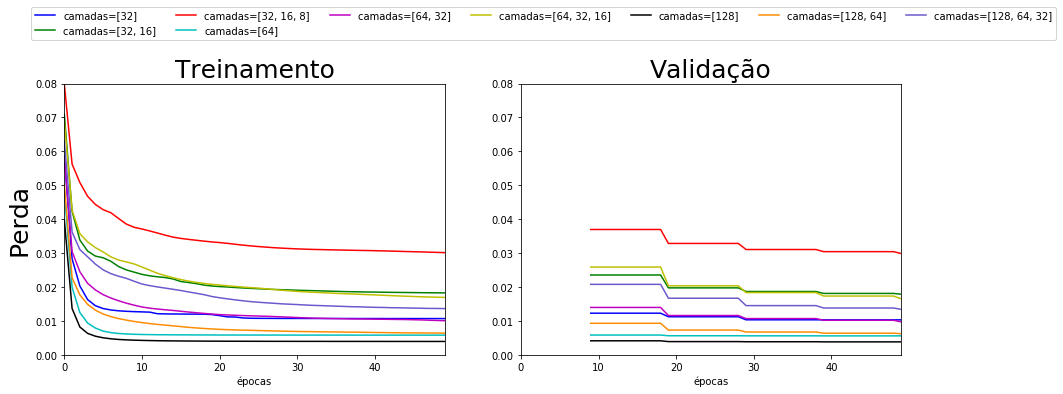

In [92]:
colors = ['b','g','r','c','m','y','k','darkorange', 'slateblue', 'lime', 'tan']
display(HTML(
'<b><center>Perda Durante o Treinamento para o Dataset MNIST com Redes que Possuem Camadas não Lineares</b></center>'
))
plot_learning_curve(models_results_mnist, params, colors, 'camadas', ylim=[0,0.08] )

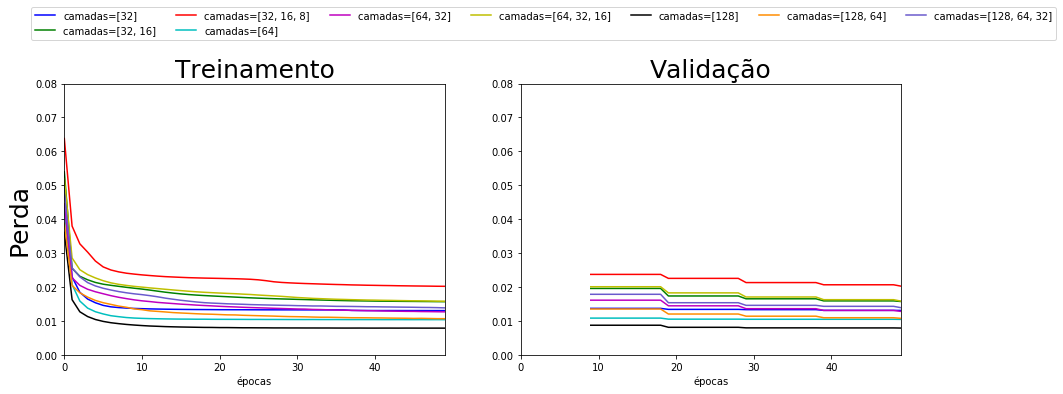

In [93]:
display(HTML(
'<b><center>Perda Durante o Treinamento para o Dataset Fashion MNIST com Redes que Possuem Camadas não Lineares</b></center>'
))
plot_learning_curve(models_results_f_mnist, params, colors, 'camadas', ylim=[0,0.08] )

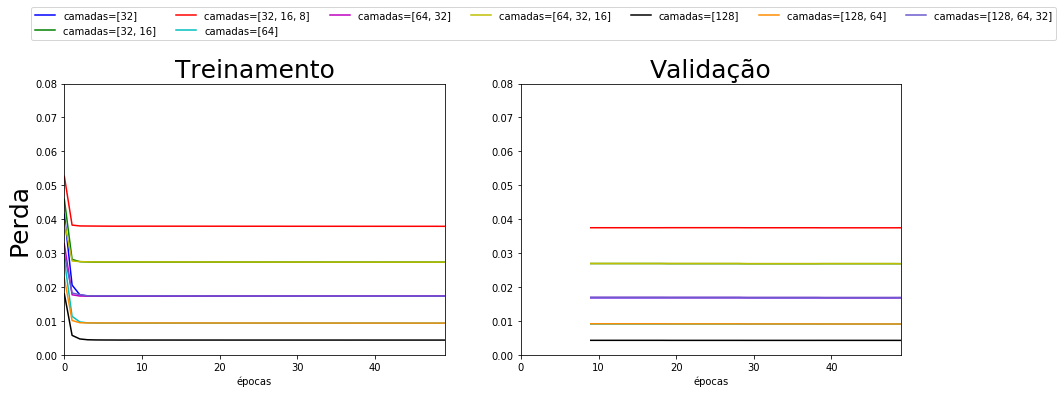

In [94]:
display(HTML(
'<b><center>Perda Durante o Treinamento para o Dataset MNIST com Redes que Possuem Apenas Camadas Lineares</b></center>'
))
plot_learning_curve(models_results_mnist_linear, params, colors, 'camadas', ylim=[0,0.08] )

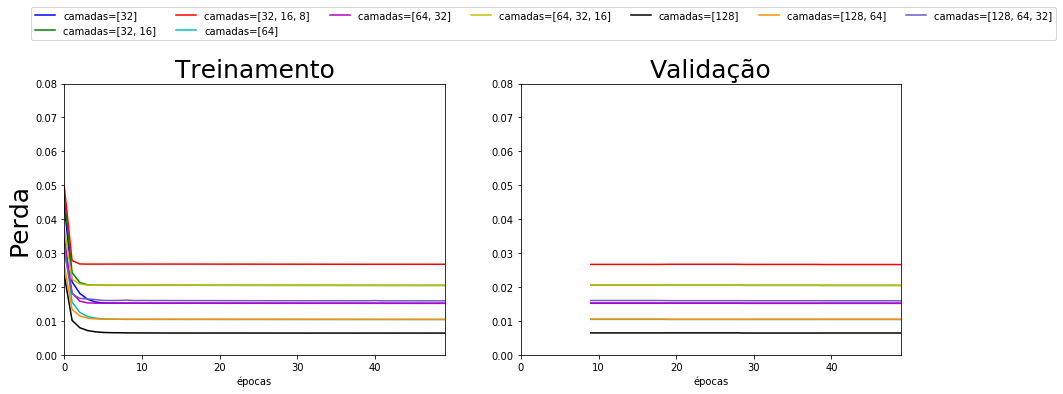

In [95]:
display(HTML(
'<b><center>Perda Durante o Treinamento para o Dataset Fashion MNIST com Redes que Possuem Apenas Camadas Lineares</b></center>'
))
plot_learning_curve(models_results_f_mnist_linear, params, colors, 'camadas', ylim=[0,0.08] )

A seguir serão apresentados lado a lado a imagem de entrada da rede, a representação gerada pela primeira camada e a saída para cada um dos tipos de experimentos realizados.

Pode ser observado que as saídas geradas pelas redes são muito similar as entradas, havendo apenas a perda de alguns pequenos detalhes da imagem e que as redes que utilizam camadas não lineares apresentaram uma imagem um pouco mais nítida que as que possuem apenas camadas lineares. 

Em relação à codificação da primeira camada, é possível observar que algumas classes apresentaram codificações bastante diferentes (como, por exemplo calças e blusas do dataset Fashion MNIST), no entanto, é difícil realizar a interpretação desses dados apenas visualmente.

Pode ser notado, através da comparação da codificação das redes com camadas não lineares e redes apenas com camadas lineares, que nas primeiras, devido à função de ativação ReLu, a codificação possuí apenas valores positivos, enquanto nas segundas, valores negativos são permitidos.

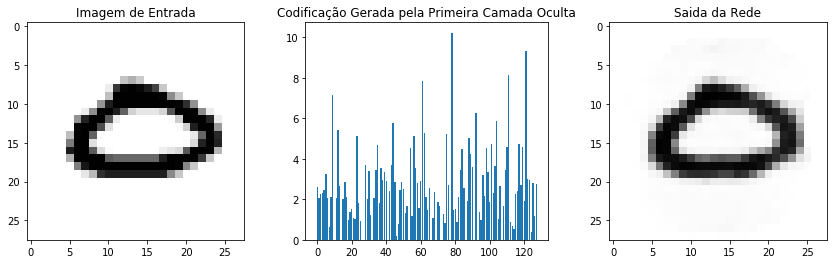

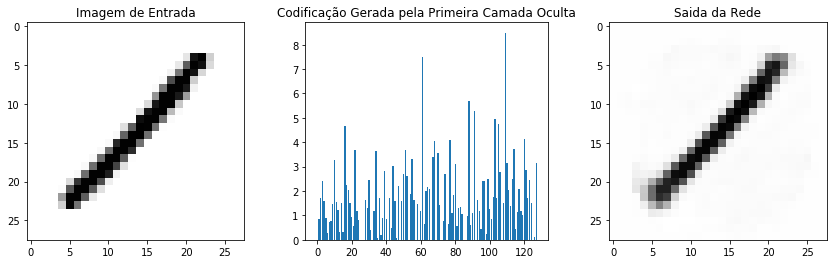

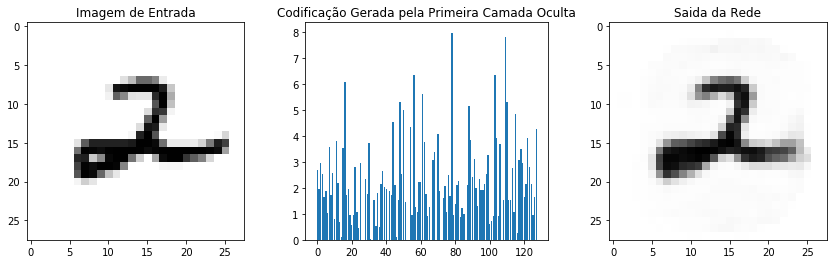

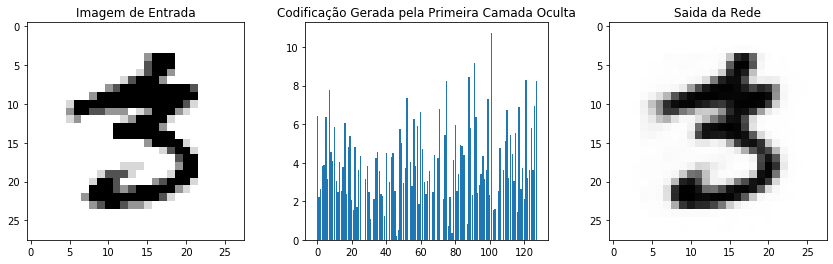

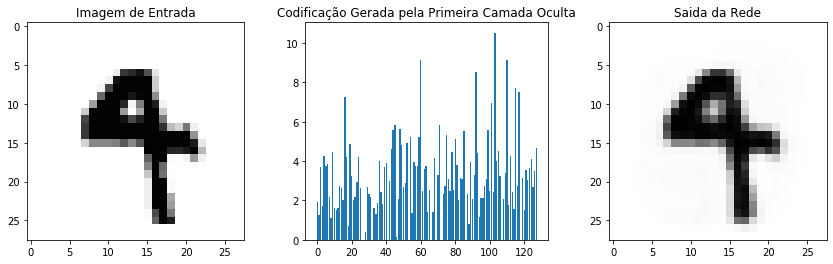

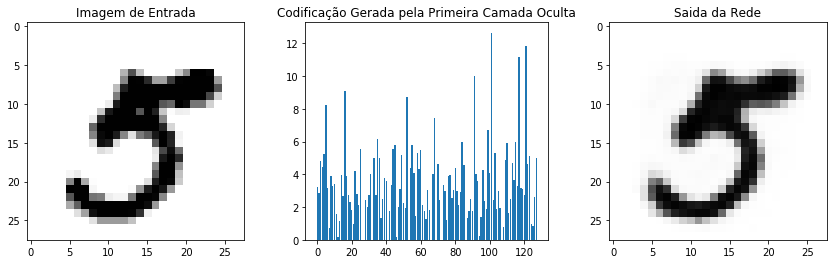

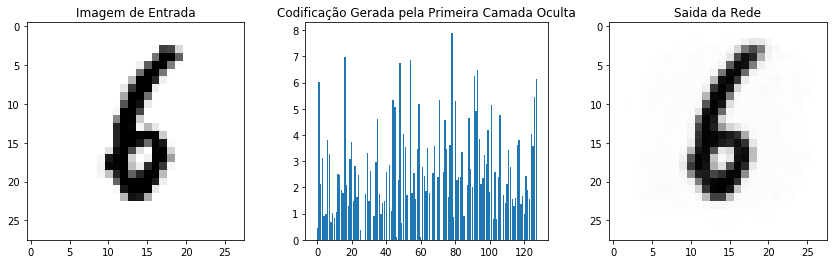

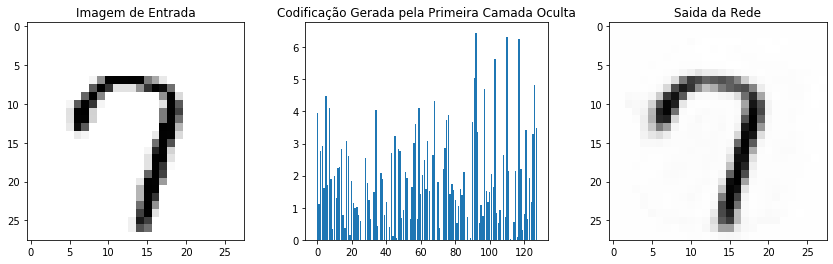

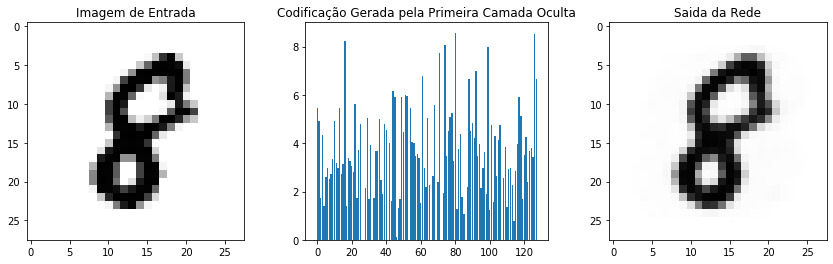

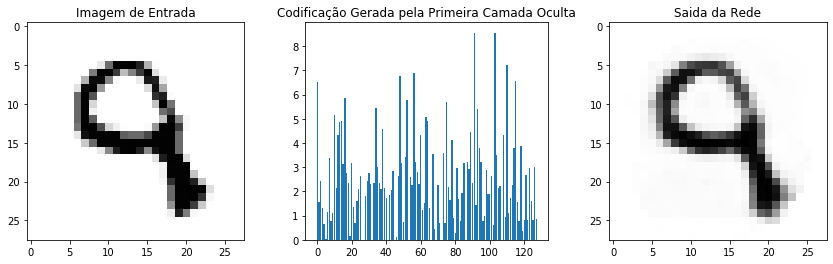

In [96]:
display(HTML(
'<b><center>Imagem de Entrada, Representação Gerada pela Primeira Camada e Saída para o Dataset MNIST Com a Melhor Rede que Possui Camadas Não Lineares</b></center>'))
plot_examples_autoencoder( loader_mnist_val, mnist_best_model )

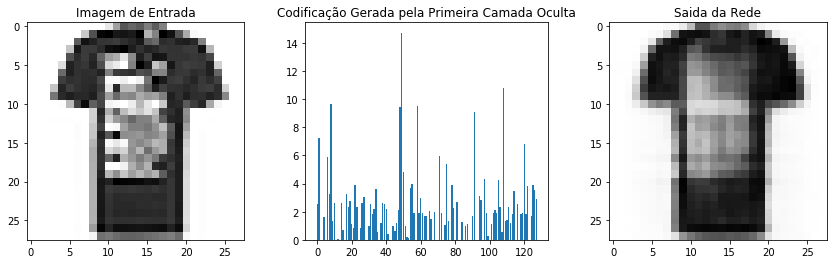

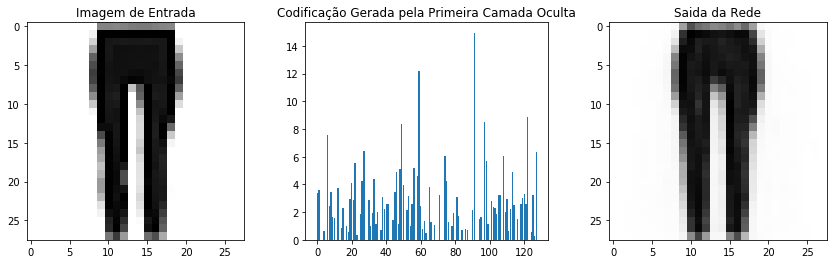

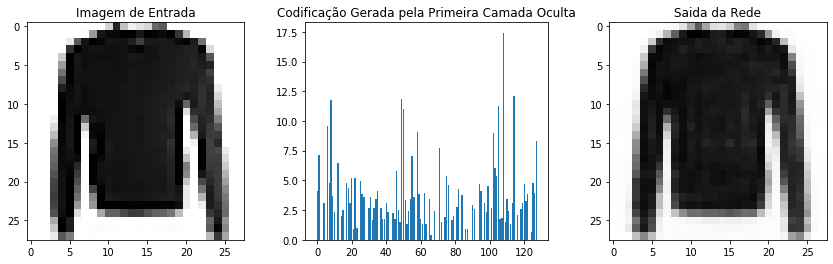

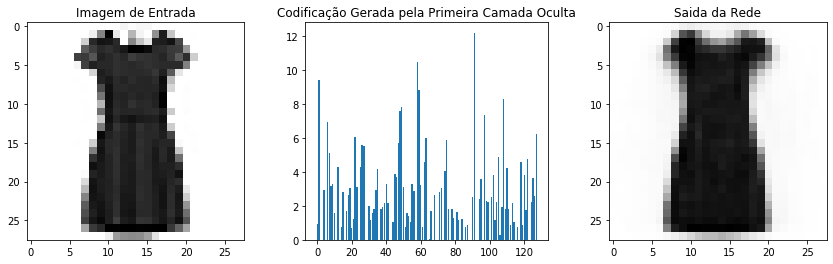

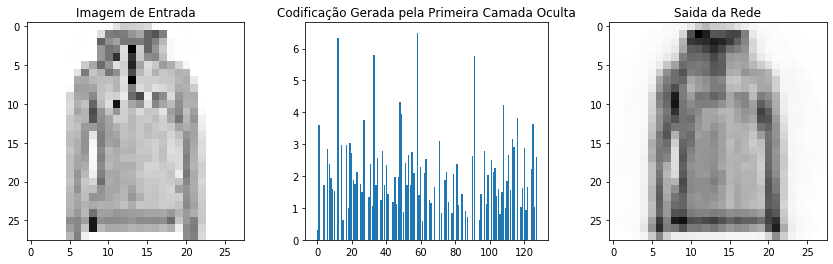

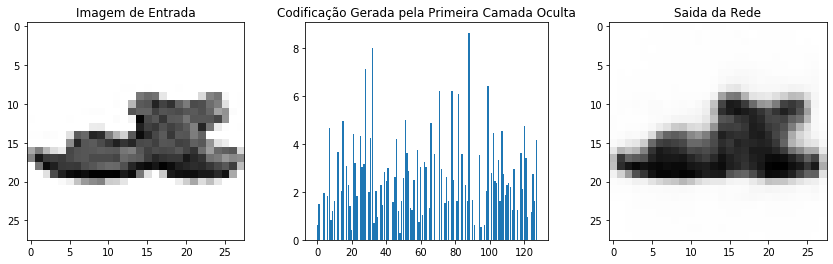

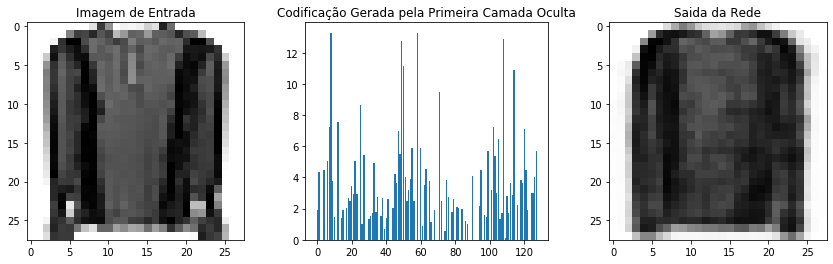

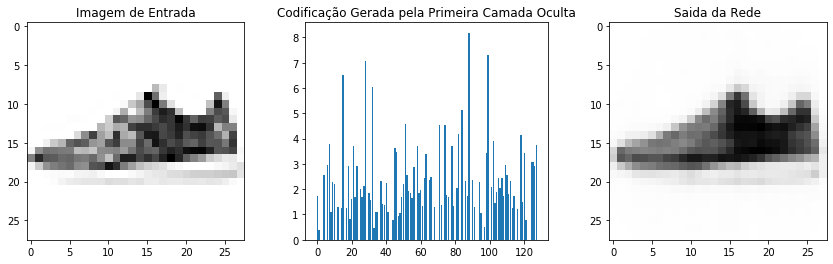

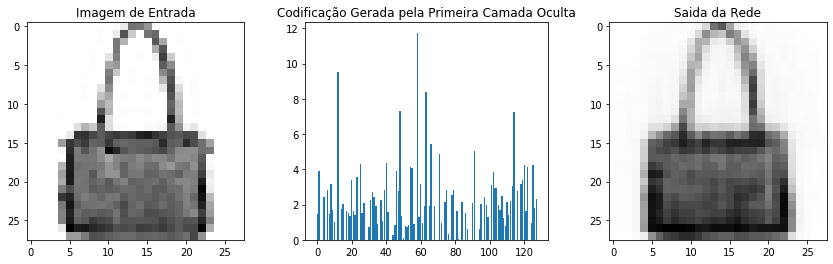

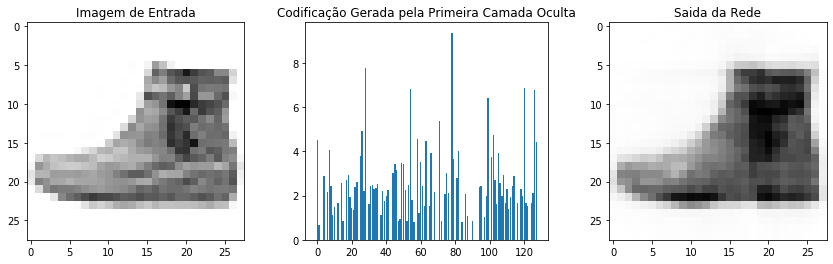

In [97]:
display(HTML(
'<b><center>Imagem de Entrada, Representação Gerada pela Primeira Camada e Saída para o Dataset Fashion MNIST Com a Melhor Rede que Possui Camadas Não Lineares</b></center>'))
plot_examples_autoencoder( loader_f_mnist_val, f_mnist_best_model )

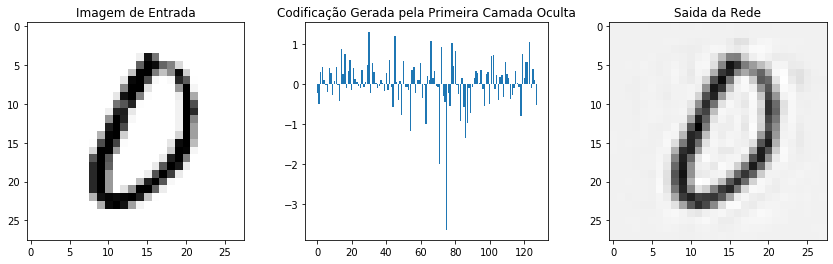

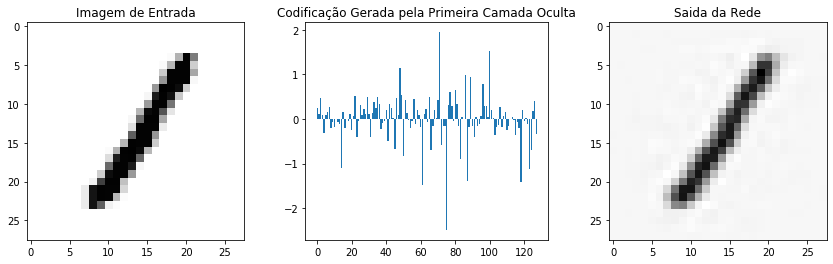

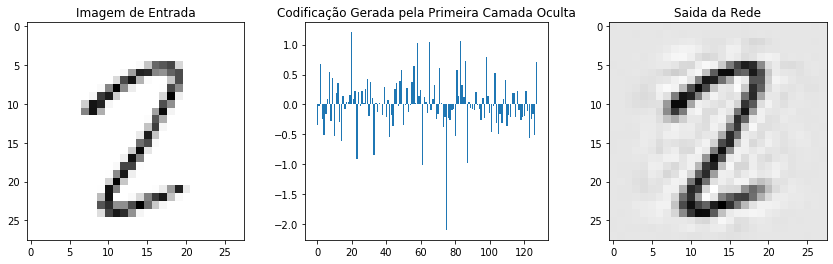

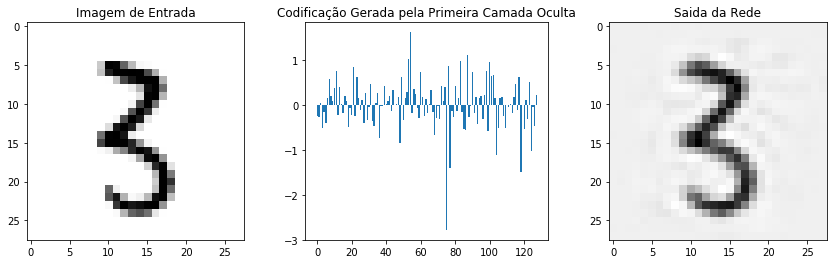

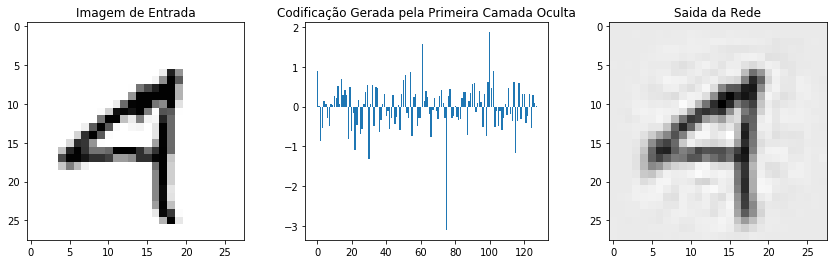

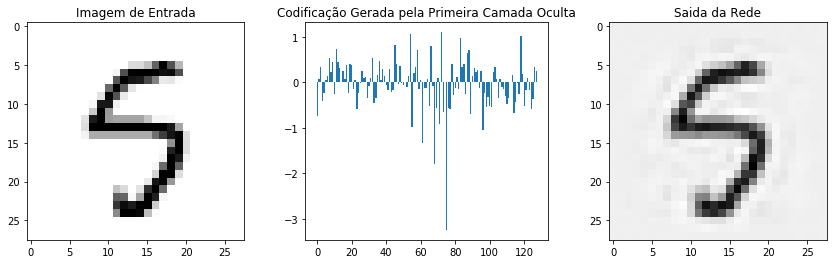

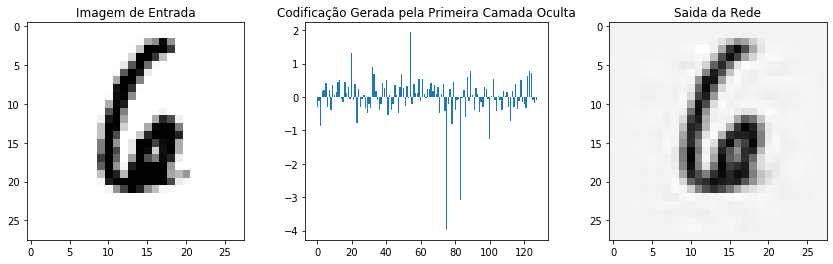

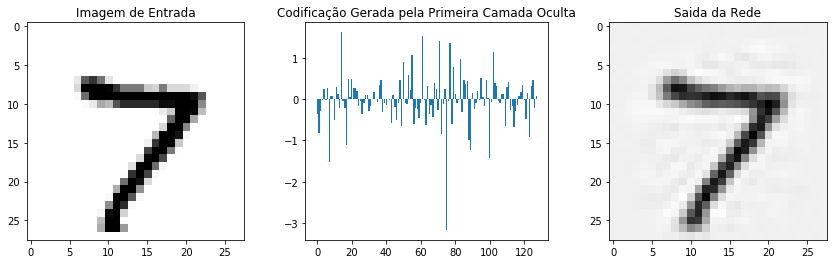

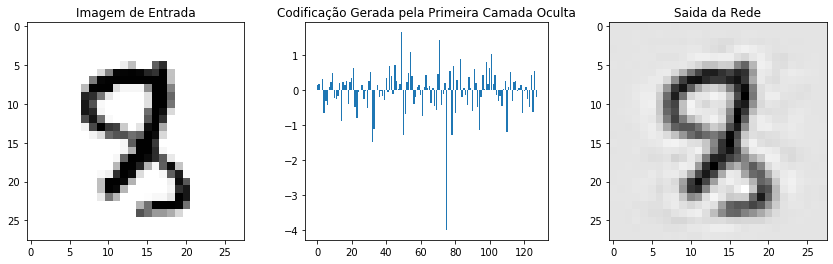

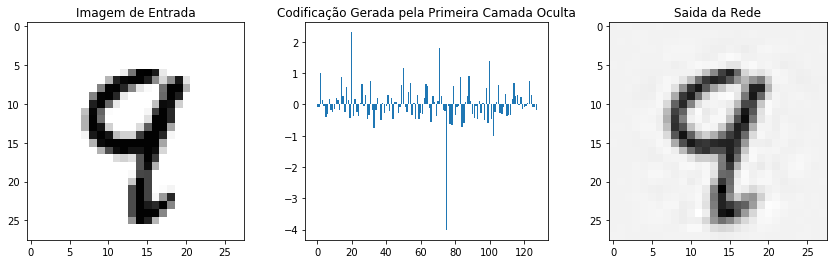

In [98]:
display(HTML(
'<b><center>Imagem de Entrada, Representação Gerada pela Primeira Camada e Saída para o Dataset MNIST Com a Melhor Rede que Possui Apenas Camadas Lineares</b></center>'))
plot_examples_autoencoder( loader_mnist_val, mnist_best_model_linear )

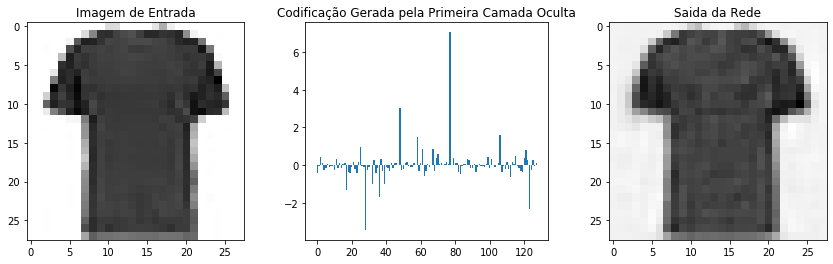

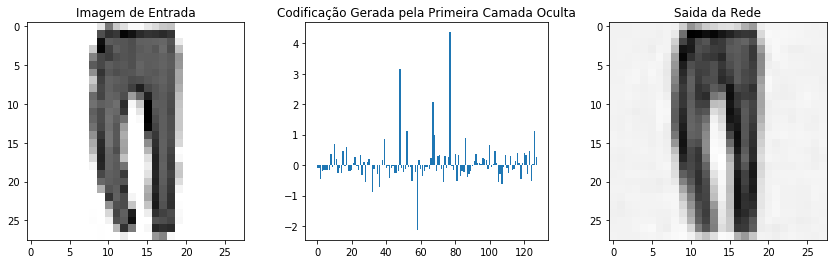

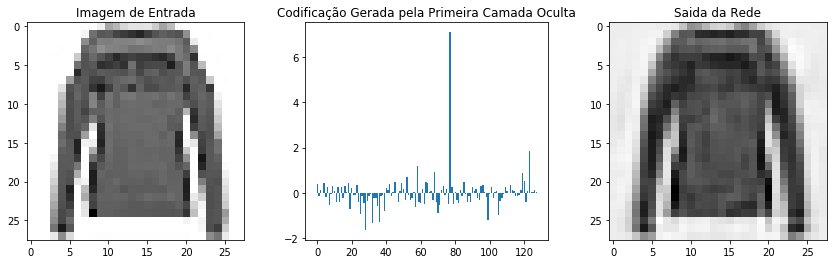

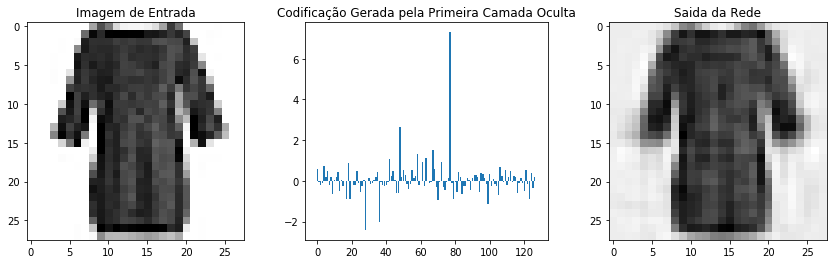

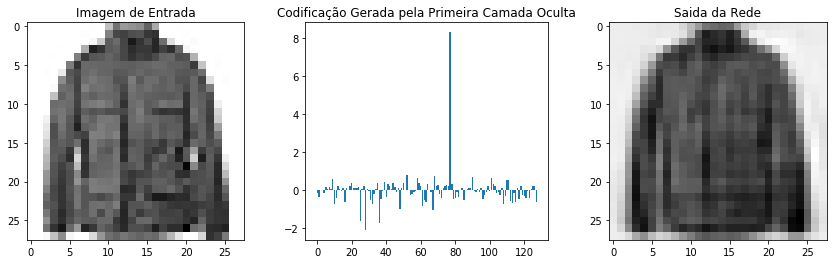

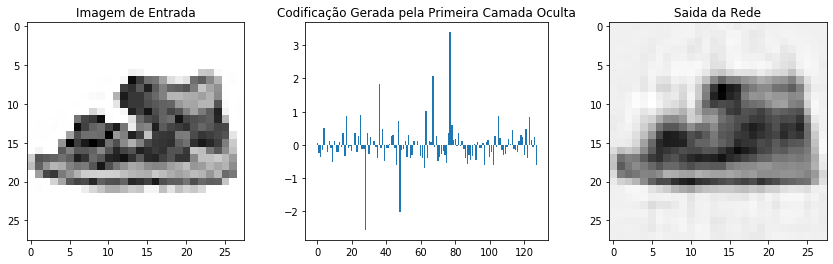

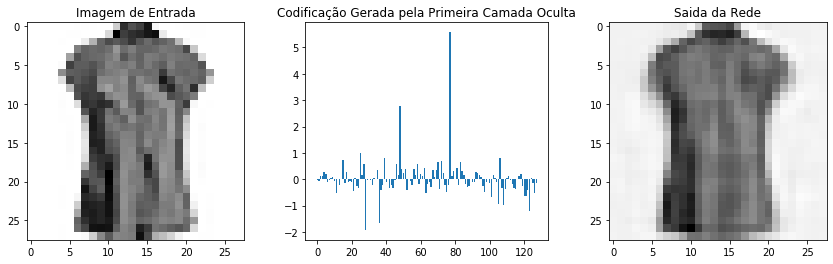

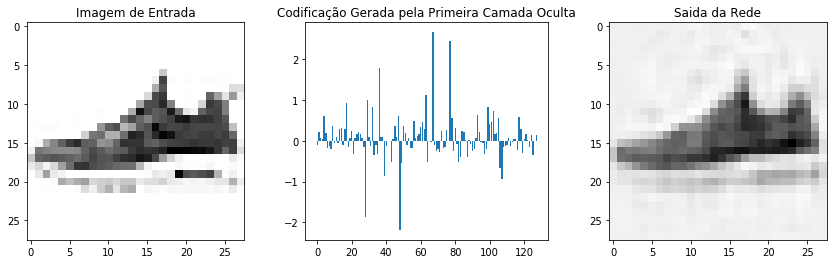

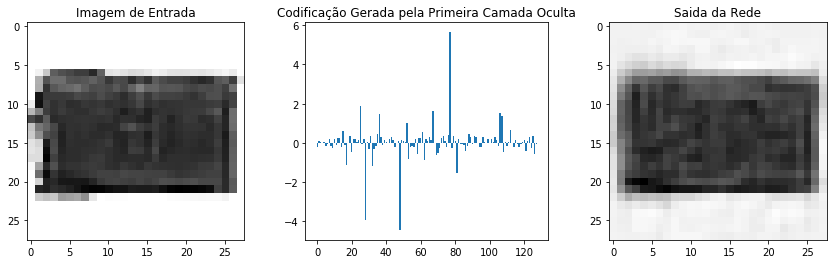

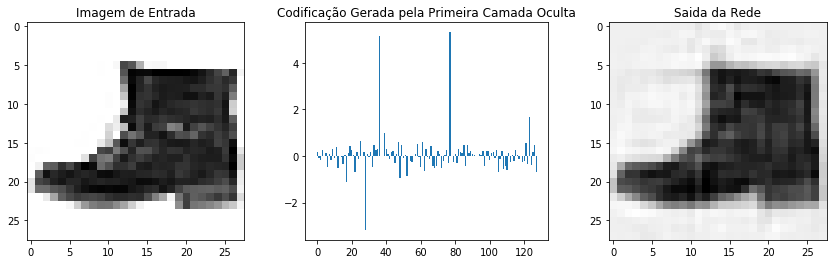

In [99]:
display(HTML(
'<b><center>Imagem de Entrada, Representação Gerada pela Primeira Camada e Saída para o Dataset Fashion MNIST Com a Melhor Rede que Possui Apenas Camadas Lineares</b></center>'))
plot_examples_autoencoder( loader_f_mnist_val, f_mnist_best_model_linear )

## Conclusão

Nesse projeto foram realizados experimentos com autoencoders, variando a quantidade de camadas e neurônios em cada camada, além da utilização de ativações não lineares ou apenas lineares, sendo os resultados avaliados nos datasets MNIST e Fashion MNIST.

Foram obtidos resultados satisfatórios, encontrando arquiteturas que obtiveram baixos erros quadráticos médios para ambos datasets e cuja imagem de saída e muito similar a de entrada, sendo perdidos apenas alguns poucos detalhes.

A quantidade de neurônios na última camada do encoder se mostrou como o fator de maior influência no resultado, sendo observado que quantidades maiores leavam a um melhor desempenho, isso foi atribuído ao fato de se perder menos informação ao se codificar uma imagem em uma quantidade maior de valores.

Foi notado também que as redes com apenas camadas lineares e as que possuem camadas não lineares obtiveram resultados similares e que o dataset Fashion MNIST é um pouco mais desafiador que o MNIST.